<div style="text-align: center; background-color: #556B2F; padding: 15px;">
  <h1 style="color: #fff; font-size: 35px;">E-Commerce Brasileiro</h1>
</div>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from wordcloud import WordCloud, STOPWORDS

In [2]:
# função para executar as querys no banco de dados

def execute(cod):
    
    conn = sqlite3.connect("brazillian_ecommerce.db")
    
    # criando um cursor
    cur = conn.cursor()
    
    # convertendo a query para dataset
    df = cur.execute(cod).fetchall()
    df = pd.DataFrame(df)
    
    # atribuindo o nome para as colunas
    if df.shape[1] > 0:
        df.columns = [col[0] for col in cur.description]
        
    conn.close()
        
    return df

In [3]:
# visualizando o nome das tabelas

execute('''
        SELECT name
        FROM sqlite_master
        WHERE type = 'table'
''')

,name
0,customers
1,geolocation
2,orders
3,order_items
4,order_payments
5,order_reviews
6,products
7,sellers
8,product_category_name_translation


<div style="text-align: center; background-color: #556B2F; padding: 10px;">
  <h2 style="color: #fff; font-size: 20px;">Visualização dos Dados</h1>
</div>

In [4]:
quantity_orders = execute('''
    SELECT 
        COUNT(order_id) as quantity_orders,
        (COUNT(order_id) * 100.0 / (SELECT COUNT(*) FROM orders)) as order_perc, 
        order_status
    FROM orders
    GROUP BY order_status;

''')

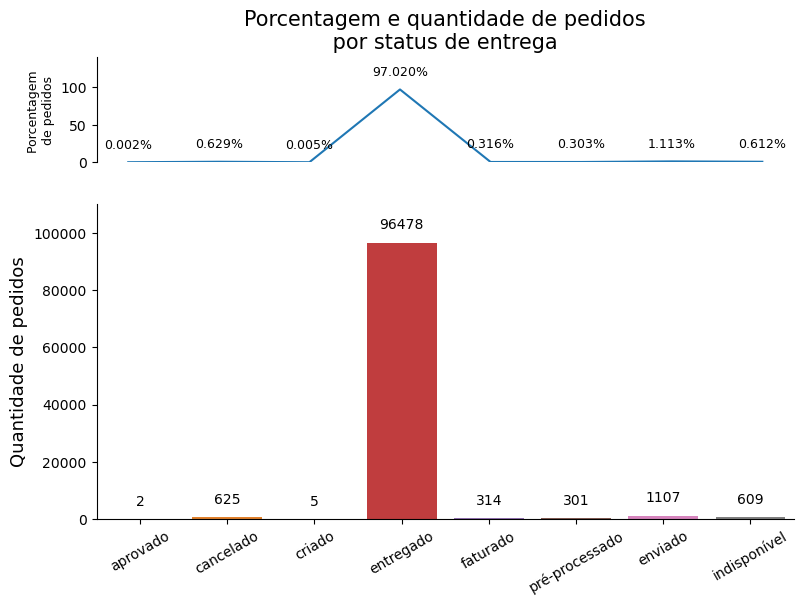

In [5]:
fig, ax = plt.subplots(nrows=2, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 3]})

sns.lineplot(data=quantity_orders, y='order_perc', x='order_status', ax=ax[0])

sns.barplot(data=quantity_orders, y='quantity_orders', x='order_status', ax=ax[1])

ax[0].set_title('Porcentagem e quantidade de pedidos\n por status de entrega ', fontsize=15)
ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('Porcentagem \nde pedidos', fontsize=9)
ax[0].spines[['top', 'right', 'bottom']].set_visible(False)

ax[0].set_ylim(0, 130)

for i, val in enumerate(quantity_orders.values[:, 1]):
    ax[0].annotate(
        text=f'{val:.3f}%',
        xy=(i, val),
        ha='center',
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=9
    )

ax[1].set_xlabel('')
ax[1].set_ylabel('Quantidade de pedidos', fontsize=13)
ax[1].tick_params(axis='x', rotation=30)

ax[1].spines[['top', 'right']].set_visible(False)
ax[1].set_xticklabels(['aprovado', 'cancelado', 'criado', 'entregado', 'faturado', 'pré-processado', 'enviado', 'indisponível'])

for i, val in enumerate(quantity_orders.values[:, 0]):
    ax[1].annotate(
        text=val,
        xy=(i, val),
        ha='center',
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=10
    )
    
ax[1].set_ylim(0, 110000)
ax[0].set_ylim(0, 140)

plt.show()

> - 97% dos pedidos foram entregues com sucesso
> - vamos dar uma olhada em pedidos atrasados e antecipados

In [6]:
orders = execute('''
    SELECT 
        orders.order_id,
        order_delivered_customer_date,
        order_estimated_delivery_date,
        review_score,
        review_comment_message
    FROM orders
    INNER JOIN order_reviews
        ON orders.order_id = order_reviews.order_id
''')

orders.head(3)

,order_id,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18 00:00:00,4,"Não testei o produto ainda, mas ele veio corre..."
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13 00:00:00,4,Muito bom o produto.
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04 00:00:00,5,None


In [7]:
# verificando o tipo das colunas

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99224 non-null  object
 1   order_delivered_customer_date  96359 non-null  object
 2   order_estimated_delivery_date  99224 non-null  object
 3   review_score                   99224 non-null  int64 
 4   review_comment_message         40977 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


> - as colunas 'order_delivered_customer_date' e 'order_estimated_delivery_date' não estão no tipo de data

In [8]:
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'],
                                                       format='%Y-%m-%d %H:%M:%S').dt.strftime('%d-%m-%Y')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'],
                                                       format='%d-%m-%Y')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'],
                                                       format='%Y-%m-%d %H:%M:%S').dt.strftime('%d-%m-%Y')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'],
                                                       format='%d-%m-%Y')

In [9]:
# verificandonovamente os tipos

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99224 non-null  object        
 1   order_delivered_customer_date  96359 non-null  datetime64[ns]
 2   order_estimated_delivery_date  99224 non-null  datetime64[ns]
 3   review_score                   99224 non-null  int64         
 4   review_comment_message         40977 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 3.8+ MB


In [10]:
# criando uma feature de acordo com os dias de atraso ou dias antecipados da entrega

orders['early_days'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']).dt.days

In [11]:
# criando uma outra feature que representará o status dos pedidos. 0 = com atraso, 1 = sem atraso

orders['delivery_status'] = orders.early_days.apply(lambda val: 0 if val < 0 else 1)

In [12]:
orders[orders.delivery_status == 0].head(3)

,order_id,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,early_days,delivery_status
19,203096f03d82e0dffbc41ebc2e2bcfb7,2017-10-09,2017-09-28,2,os correios estäo em greve... näo recebi nenhu...,-11.0,0
24,fbf9ac61453ac646ce8ad9783d7d0af6,2018-03-21,2018-03-12,2,Demora muito entregar. Já passou o prazo e ain...,-9.0,0
40,6ea2f835b4556291ffdc53fa0b3b95e8,2017-12-28,2017-12-21,1,"Inicialmente, na data da compra o produto era ...",-7.0,0


In [13]:
stts = orders.delivery_status.value_counts()

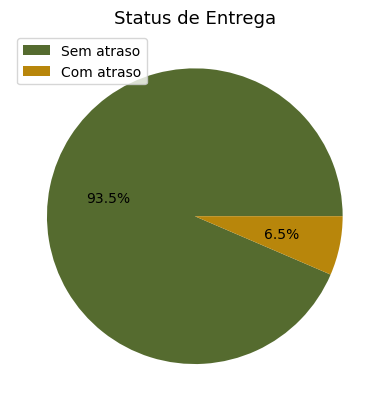

In [14]:
fig, ax = plt.subplots()

ax.pie(stts.values, labels=['', ''], autopct='%1.1f%%', colors=['#556B2F', '#B8860B'])

ax.set_title('Status de Entrega', fontsize=13)

ax.legend(['Sem atraso', 'Com atraso'])
plt.show()

> - 93,5% das entregas bem-sucedidas foram entregues antes do prazo

In [15]:
orders['month'] = orders.order_delivered_customer_date.dt.to_period('m')

In [16]:
orders.groupby('month')['order_id'].count()

month
2016-10     209
2016-11      59
2016-12       3
2017-01     283
2017-02    1354
2017-03    2378
2017-04    1842
2017-05    3760
2017-06    3230
2017-07    3454
2017-08    4321
2017-09    3956
2017-10    4499
2017-11    4673
2017-12    7197
2018-01    6567
2018-02    5843
2018-03    6871
2018-04    7807
2018-05    7079
2018-06    6810
2018-07    5825
2018-08    8281
2018-09      55
2018-10       3
Freq: M, Name: order_id, dtype: int64

> - podemos observar que alguns períodos possuem poucos pedidos, vamos excluí-los

In [17]:
orders.drop(orders.index[(orders.month <= '2017-01') | (orders.month >= '2018-09')], axis=0, inplace=True)

> - agora podemos analisar os pedidos por mês

In [18]:
min_orders = orders.groupby('month')['early_days'].min()
max_orders = orders.groupby('month')['early_days'].max()
avg_orders = orders.groupby('month')['early_days'].mean()

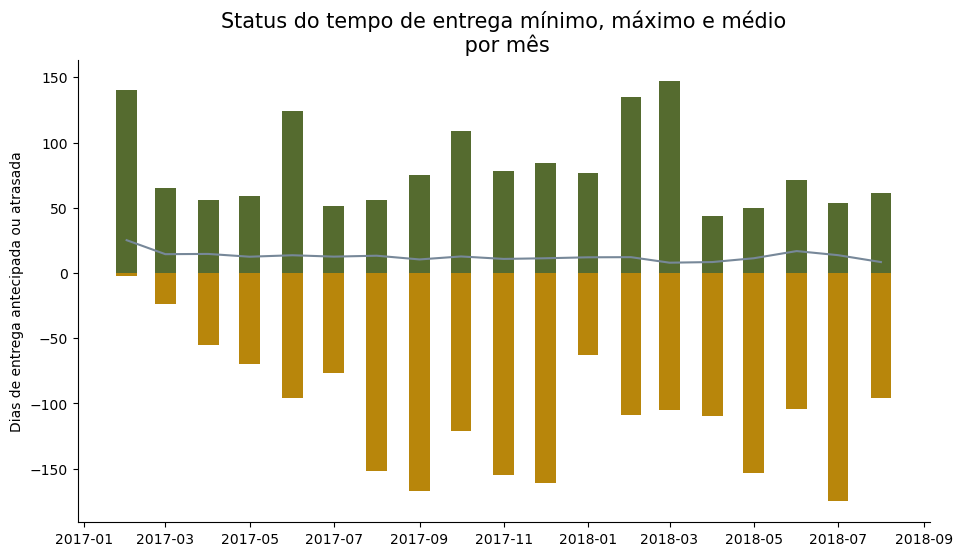

In [19]:
fig, ax = plt.subplots(figsize=(11, 6))

ax.bar(max_orders.index.to_timestamp(), max_orders.values, width=15, color='#556B2F')
ax.plot(avg_orders.index.to_timestamp(), avg_orders.values, color='#778899')
ax.bar(min_orders.index.to_timestamp(), min_orders.values, width=15, color='#B8860B')

ax.set_title('Status do tempo de entrega mínimo, máximo e médio\n por mês', fontsize=15)
ax.set_ylabel('Dias de entrega antecipada ou atrasada', fontsize=10)

ax.spines[['top', 'right']].set_visible(False)

plt.show()

> - os valores de algumas entregas são completamente discrepantes
> - vamos ver como essa entrega afeta as avaliações dos clientes

In [20]:
early_days = orders[orders.delivery_status == 1].groupby('review_score')['order_id'].count()
late_days = orders[orders.delivery_status == 0].groupby('review_score')['order_id'].count()

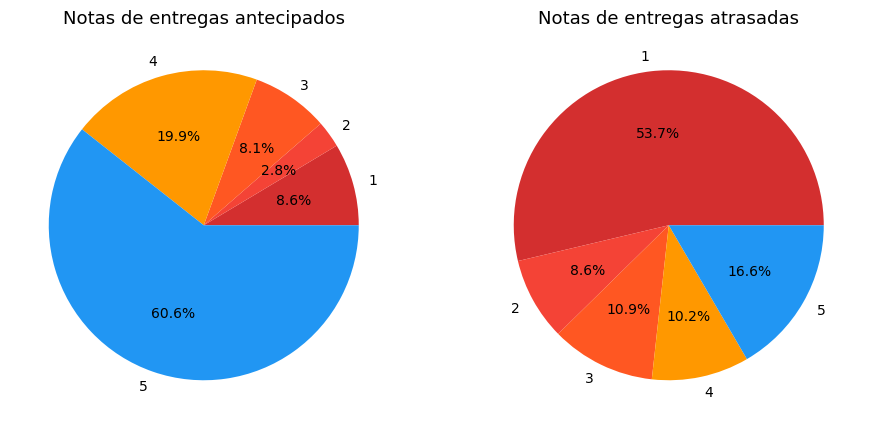

In [21]:
colors = ['#D32F2F', '#F44336', '#FF5722', '#FF9800', '#2196F3']

fig, ax = plt.subplots(ncols=2, figsize=(11, 6))

ax[0].pie(early_days.values, labels=early_days.index, autopct='%1.1f%%', colors=colors)
ax[1].pie(late_days.values, labels=late_days.index, autopct='%1.1f%%', colors=colors)

ax[0].set_title('Notas de entregas antecipados', fontsize=13)
ax[1].set_title('Notas de entregas atrasadas', fontsize=13)

plt.show()

> - podemos ver claramente que o atraso no pedido afeta drasticamente a satisfação do cliente
> - vamos dar uma olhada nas mensagens de avaliação do cliente

In [22]:
message_late = orders.loc[(orders.delivery_status == 0)
                          & (orders.review_comment_message.notnull()), 'review_comment_message']
message_early = orders.loc[(orders.delivery_status == 1)
                           & (orders.review_comment_message.notnull()), 'review_comment_message']

In [23]:
text_reviews_late = ' '.join(message_late.astype(str))
text_reviews_early = ' '.join(message_early.astype(str))

In [24]:
stopwords = set(STOPWORDS)
stopwords.update(['o', 'produto', 'que', 'e', 'é', 'ma'])

In [25]:
wc_late = WordCloud(width=800, height=500, background_color='white',
                    max_words=50, max_font_size=130, stopwords=stopwords).generate(text_reviews_late)
wc_early = WordCloud(width=800, height=500, background_color='white',
                     max_words=50, max_font_size=130, stopwords=stopwords).generate(text_reviews_early)

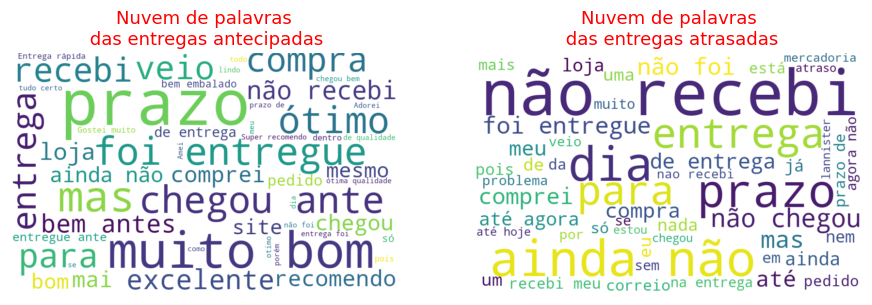

In [26]:
fig, ax = plt.subplots(figsize=(11, 6), ncols=2)

ax[0].set_title('Nuvem de palavras\n das entregas antecipadas', fontsize=13, color='red')
ax[0].imshow(wc_early, interpolation='bilinear')
ax[0].axis('off')

ax[1].set_title('Nuvem de palavras\n das entregas atrasadas', fontsize=13, color='red')
ax[1].imshow(wc_late, interpolation='bilinear')
ax[1].axis('off')

plt.show()

> - agora podemos realmente concluir que o atraso no pedido influencia a satisfação do cliente
> - frases com ‘não recebi’, ‘não chegou’, ‘ainda não’ estão presentes na nuvem de palavras em pedidos atrasados
> - enquanto isso, frases como 'ótimo', 'chegou antes', 'muito bom' aparecem na nuvem de palavras de pedidos que não atrasaram.